# Analyze Index Stock Performance
SPX, QQQ, DOW

In [1]:
!pip install requests pandas yfinance investpy lxml beautifulsoup4 polygon-api-client investpy tabulate openpyxl

!pip install gspread gspread-dataframe oauth2client

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor


## Fetch and save index components

In [3]:
# Fetch index components 
def fetch_components_slickcharts(index):
    base_url = "https://slickcharts.com/"
    index_map = {
        'QQQ': 'nasdaq100',
        'SPX': 'sp500',
        'DOW': 'dowjones',
        'IWM': 'russell2000'
    }
    if index.upper() not in index_map:
        raise ValueError("Index must be either 'QQQ', 'SPX', 'DOW', or 'IWM'")
    
    url = f"{base_url}{index_map[index.upper()]}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find('table', {'class': 'table'})
    
    data = []
    headers = []

    for i, row in enumerate(table.find_all('tr')):
        cols = [ele.text.strip() for ele in row.find_all('td')]
        if i == 0:
            headers = [ele.text.strip() for ele in row.find_all('th')]
        else:
            if len(cols) > 1:  # Ensure there is data in the row
                data.append(cols)
    
    df = pd.DataFrame(data, columns=headers)
    return df

In [4]:
# Append components with industry info
from collections import Counter
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

def fetch_company_info(symbol):
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        industry = info.get("industry", "N/A")
        sector = info.get("sector", "N/A")
        #print(f"Fetched industry and sector for {symbol}: {industry}, {sector}")
        return industry, sector
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return "N/A", "N/A"

def append_company_info(df):
    industries = []
    sectors = []
    for _, row in df.iterrows():
        symbol = row['Symbol']
        industry, sector = fetch_company_info(symbol)
        industries.append(industry)
        sectors.append(sector)
    
    df['Industry'] = industries
    df['Sector'] = sectors
    return df

def print_all_company_details_compact(df, rank_by='weight'):
    # Print DataFrame columns for debugging
    print("DataFrame columns:", df.columns)
    
    # Convert 'Weight' or 'Portfolio %' column to numeric if it exists
    weight_column = 'Weight' if 'Weight' in df.columns else 'Portfolio%' if 'Portfolio%' in df.columns else None
    
    if rank_by == 'weight' and weight_column:
        df[weight_column] = df[weight_column].astype(str).str.replace('%', '').astype(float)
        df = df.sort_values(by=weight_column, ascending=False)
    elif rank_by == 'industry' and 'Industry' in df.columns:
        df = df.sort_values(by='Industry')
    elif rank_by == 'sector' and 'Sector' in df.columns:
        df = df.sort_values(by='Sector')
    
    # Get the maximum length of each column for formatting
    col_widths = [max(df[col].astype(str).map(len).max(), len(col)) for col in df.columns]
    format_str = ' | '.join([f'{{:<{width}}}' for width in col_widths])
    
    print(format_str.format(*df.columns))
    print('-' * (sum(col_widths) + 3 * (len(col_widths) - 1)))
    
    for index, row in df.iterrows():
        print(format_str.format(*row))

# Example usage:
# df = pd.DataFrame({'Symbol': ['AAPL', 'MSFT', 'GOOGL']})
# df = append_company_info(df)
# print_all_company_details_compact(df)

In [6]:
from tabulate import tabulate

def display_industry_stats(df):
    industry_stats = df['Industry'].value_counts().reset_index()
    industry_stats.columns = ['Industry', 'Number of Companies']
    industry_stats = industry_stats.sort_values(by='Industry')
    
    data = []
    for industry in industry_stats['Industry']:
        tickers = df[df['Industry'] == industry]['Symbol'].tolist()
        ticker_string = ", ".join(tickers)
        data.append([industry, len(tickers), ticker_string])
    
    print(tabulate(data, headers=["Industry", "Number of Companies", "Tickers"], tablefmt="grid", stralign="left"))


def display_sector_stats(df):
    sector_stats = df['Sector'].value_counts().reset_index()
    sector_stats.columns = ['Sector', 'Number of Companies']
    sector_stats = sector_stats.sort_values(by='Sector')
    
    data = []
    for sector in sector_stats['Sector']:
        tickers = df[df['Sector'] == sector]['Symbol'].tolist()
        ticker_string = ", ".join(tickers)
        data.append([sector, len(tickers), ticker_string])
    
    print(tabulate(data, headers=["Sector", "Number of Companies", "Tickers"], tablefmt="grid", stralign="left"))

In [18]:
import os

def load_or_fetch_data(file_path, index_name):
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        print(f"Loaded data from {file_path}")
    else:
        df = append_company_info(fetch_components_slickcharts(index_name))
        # Select only the desired columns
        columns_to_save = ['#', 'Company', 'Symbol', 'Portfolio%', 'Industry', 'Sector']
        df = df[columns_to_save]
        df.to_excel(file_path, index=False)
        print(f"Fetched data from Slickcharts and saved to {file_path}")
    return df

# Load data for QQQ and SPX
df_qqq = load_or_fetch_data('df_qqq.xlsx', 'qqq')
df_spx = load_or_fetch_data('df_spx.xlsx', 'spx')


Fetched data from Slickcharts and saved to df_qqq.xlsx
Fetched data from Slickcharts and saved to df_spx.xlsx


In [17]:
unique_sectors = df_spx['Sector'].unique()
print(f"Number of unique sectors: {num_sectors}")
print("List of unique sectors:")
for sector in unique_sectors:
    print(sector)

print("Columns in the DataFrame:")
print(df_qqq.columns)

Number of unique sectors: 11
List of unique sectors:
Technology
Consumer Cyclical
Communication Services
Healthcare
N/A
Financial Services
Energy
Consumer Defensive
Basic Materials
Industrials
Utilities
Real Estate
Columns in the DataFrame:
Index(['#', 'Company', 'Symbol', 'Portfolio%', 'Price', 'Chg', '% Chg', '',
       'Industry', 'Sector'],
      dtype='object')


## Understand Index Components

### QQQ Components

In [23]:
# Print details of all companies in a compact format
print_all_company_details_compact(df_qqq, rank_by='sector')
display_industry_stats(df_qqq)

DataFrame columns: Index(['#', 'Company', 'Symbol', 'Portfolio%', 'Industry', 'Sector'], dtype='object')
#   | Company                             | Symbol | Portfolio% | Industry                            | Sector                
------------------------------------------------------------------------------------------------------------------------------
18  | Linde PLC                           | LIN    | 1.34%      | Specialty Chemicals                 | Basic Materials       
99  | Warner Bros Discovery Inc           | WBD    | 0.12%      | Entertainment                       | Communication Services
77  | Electronic Arts Inc                 | EA     | 0.24%      | Electronic Gaming & Multimedia      | Communication Services
95  | Take-Two Interactive Software Inc   | TTWO   | 0.17%      | Electronic Gaming & Multimedia      | Communication Services
71  | DoorDash Inc                        | DASH   | 0.27%      | Internet Content & Information      | Communication Services
6   | 

### SPX Components

In [25]:
# Print details of all companies in a compact format
print_all_company_details_compact(df_spx, rank_by='sector')
display_sector_stats(df_spx)

DataFrame columns: Index(['#', 'Company', 'Symbol', 'Portfolio%', 'Industry', 'Sector'], dtype='object')
#   | Company                                        | Symbol | Portfolio% | Industry                                 | Sector                
----------------------------------------------------------------------------------------------------------------------------------------------
252 | Dupont De Nemours, Inc.                        | DD     | 0.07%      | Specialty Chemicals                      | Basic Materials       
253 | Martin Marietta Materials                      | MLM    | 0.07%      | Building Materials                       | Basic Materials       
257 | Vulcan Materials Company                       | VMC    | 0.07%      | Building Materials                       | Basic Materials       
272 | Ppg Industries, Inc.                           | PPG    | 0.06%      | Specialty Chemicals                      | Basic Materials       
231 | Dow Inc.                       

## Calculate performance 

In [37]:
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta

def calculate_performance(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    hist = stock.history(start=start_date, end=end_date)
    
    if len(hist) == 0:
        return None
    
    start_price = hist['Close'].iloc[0]
    end_price = hist['Close'].iloc[-1]
    performance = (end_price - start_price) / start_price
    return performance

def get_performance_data(symbol, company, industry, sector, start_date, end_date):
    try:
        performance = calculate_performance(symbol, start_date, end_date)
        if performance is not None:
            return (symbol, company, performance, industry, sector)
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
    return (symbol, company, None, industry, sector)  # Ensure it returns a tuple with five elements

def fetch_all_performance_data(df, start_date, end_date):
    performance_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(get_performance_data, row['Symbol'], row['Company'], row['Industry'], row['Sector'], start_date, end_date) for index, row in df.iterrows()]
        for future in as_completed(futures):
            result = future.result()
            if result and result[2] is not None:  # Check if performance is not None
                performance_data.append(result)
    
    performance_data.sort(key=lambda x: x[2], reverse=True)
    return performance_data

def get_top_bottom_stocks(df, period, top_n, bottom_n, start_date=None, end_date=None):
    if not end_date:
        end_date = datetime.now()
    
    if start_date and end_date:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
    else:
        if period == 'ytd':
            start_date = datetime(end_date.year, 1, 1)
        else:
            delta = {
                '1d': 1,
                '5d': 5,
                '1m': 30,
                '6m': 182,
                '1y': 365,
                '2y': 365*2,
                '3y': 365*3,
                '5y': 365*5,
                '10y': 365*10,
                '20y': 365*20
            }[period]
            start_date = end_date - timedelta(days=delta)
    print("Start and end dates:", start_date, end_date)
    
    performance_data = fetch_all_performance_data(df, start_date, end_date)
    
    top_stocks = performance_data[:top_n]
    bottom_stocks = performance_data[-bottom_n:]
    
    top_df = pd.DataFrame(top_stocks, columns=['Symbol', 'Company', 'Performance', 'Industry', 'Sector'])
    bottom_df = pd.DataFrame(bottom_stocks, columns=['Symbol', 'Company', 'Performance', 'Industry', 'Sector'])
    
    return top_df, bottom_df

In [75]:
from tabulate import tabulate
import matplotlib.pyplot as plt

def print_top_bottom_stocks_concise(df, title, include_industry=True):
    print(title)
    for _, row in df.iterrows():
        if include_industry:
            print(f"{row['Symbol']} | {row['Sector']} | {row['Industry']} | {row['Performance']}")
        else:
            print(f"{row['Symbol']} | {row['Sector']} | {row['Performance']}")
    print("\n")

def print_sector_counts_concise(df, title):
    print(title)
    for _, row in df.iterrows():
        print(f"{row['Sector']} | {row['Count']}")
    print("\n")

def plot_performance(df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(df['Symbol'], df['Performance'].apply(lambda x: float(x.strip('%'))), color='skyblue')
    plt.xlabel('Performance (%)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest performance at the top
    plt.show()

def print_top_bottom_stocks_concise(df, title, include_industry=True):
    print(title)
    for _, row in df.iterrows():
        if include_industry:
            print(f"{row['Symbol']} | {row['Sector']} | {row['Industry']} | {row['Performance']}")
        else:
            print(f"{row['Symbol']} | {row['Sector']} | {row['Performance']}")
    print("\n")

def print_top_bottom_stocks(top_df, bottom_df, top_n, bottom_n, include_industry=True):
    top_df = top_df.copy()
    bottom_df = bottom_df.copy()
    
    # Format performance as percentage with 1 decimal
    top_df['Performance'] = top_df['Performance'].apply(lambda x: f"{x * 100:.1f}%")
    bottom_df['Performance'] = bottom_df['Performance'].apply(lambda x: f"{x * 100:.1f}%")

    # Print top stocks in concise format
    print_top_bottom_stocks_concise(top_df, f"Top {top_n} Stocks:", include_industry)

    # # Plot top stocks performance
    # plot_performance(top_df, f"Top {top_n} Stocks Performance")

    # Display top sector count
    top_sector_count = top_df['Sector'].value_counts().reset_index()
    top_sector_count.columns = ['Sector', 'Count']
    print_sector_counts_concise(top_sector_count, f"Top {top_n} Stocks by Sector:")

    # Print bottom stocks in concise format
    print_top_bottom_stocks_concise(bottom_df, f"Bottom {bottom_n} Stocks:", include_industry)

    # # Plot bottom stocks performance
    # plot_performance(bottom_df, f"Bottom {bottom_n} Stocks Performance")

    # Display bottom sector count
    bottom_sector_count = bottom_df['Sector'].value_counts().reset_index()
    bottom_sector_count.columns = ['Sector', 'Count']
    print_sector_counts_concise(bottom_sector_count, f"Bottom {bottom_n} Stocks by Sector:")

### QQQ Performance

Start and end dates: 2023-01-01 00:00:00 2023-12-31 00:00:00
Top 30 Stocks:
NVDA | Technology | 246.1%
META | Communication Services | 183.8%
CRWD | Technology | 147.2%
AMD | Technology | 130.3%
TSLA | Consumer Cyclical | 129.9%
MDB | Technology | 114.3%
PANW | Technology | 113.0%
AVGO | Technology | 106.3%
DASH | Communication Services | 104.5%
ZS | Technology | 101.1%
INTC | Technology | 92.4%
LRCX | Technology | 91.4%
MELI | Consumer Cyclical | 90.2%
TEAM | Technology | 88.0%
ADBE | Technology | 77.1%
AMZN | Consumer Cyclical | 77.0%
BKNG | Consumer Cyclical | 74.5%
PDD | Consumer Cyclical | 73.1%
CDNS | Technology | 70.6%
MU | Technology | 70.6%
AMAT | Technology | 69.1%
MRVL | Technology | 68.5%
DDOG | Technology | 68.4%
NFLX | Communication Services | 65.1%
TTD | Technology | 63.5%
WDAY | Technology | 63.0%
SNPS | Technology | 61.1%
INTU | Technology | 60.9%
ABNB | Consumer Cyclical | 60.4%
CPRT | Industrials | 59.5%




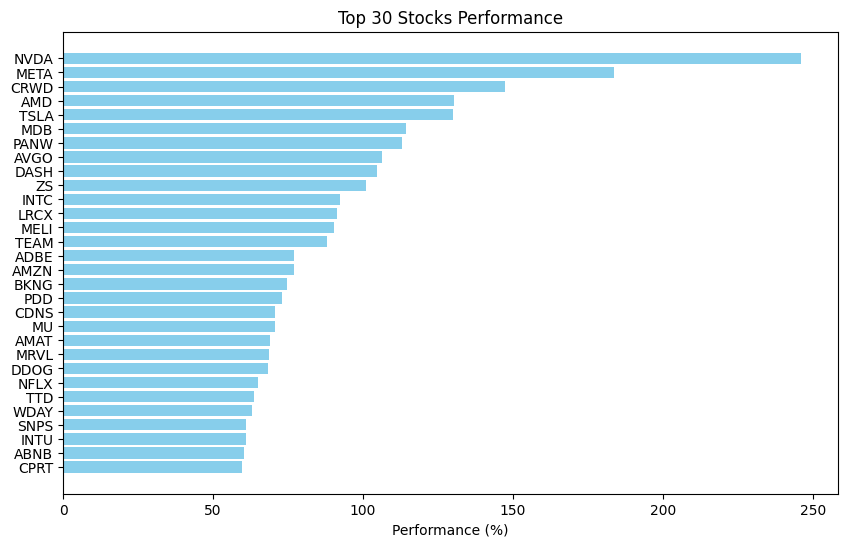

Top 30 Stocks by Sector:
Technology | 20
Consumer Cyclical | 6
Communication Services | 3
Industrials | 1


Bottom 30 Stocks:
TMUS | Communication Services | 15.8%
AMGN | Healthcare | 13.9%
CSX | Industrials | 13.9%
CHTR | Communication Services | 13.8%
MNST | Consumer Defensive | 13.7%
ORLY | Consumer Cyclical | 13.0%
CSGP | Real Estate | 12.5%
EA | Communication Services | 12.1%
MDLZ | Consumer Defensive | 11.8%
CSCO | Technology | 8.6%
DXCM | Healthcare | 8.2%
TXN | Technology | 7.7%
PAYX | Industrials | 6.0%
DLTR | Consumer Defensive | 1.3%
ADP | Industrials | 0.3%
HON | Industrials | 0.0%
AZN | Healthcare | -0.8%
GILD | Healthcare | -1.5%
PEP | Consumer Defensive | -2.6%
SBUX | Consumer Cyclical | -2.8%
KDP | Consumer Defensive | -3.9%
BIIB | Healthcare | -5.1%
KHC | Consumer Defensive | -5.2%
XEL | Utilities | -8.6%
AEP | Utilities | -10.9%
EXC | Utilities | -13.8%
PYPL | Financial Services | -17.7%
WBA | Healthcare | -24.7%
ILMN | Healthcare | -30.7%
MRNA | Healthcare | -44.4%



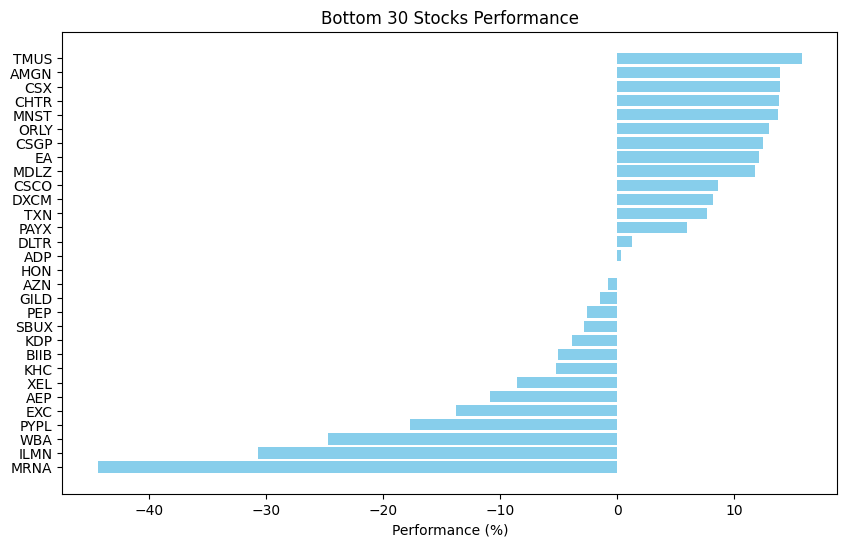

Bottom 30 Stocks by Sector:
Healthcare | 8
Consumer Defensive | 6
Industrials | 4
Communication Services | 3
Utilities | 3
Consumer Cyclical | 2
Technology | 2
Real Estate | 1
Financial Services | 1




In [57]:
# Parameters
index = 'QQQ'  # Change to 'QQQ' for Nasdaq-100, 'DOW' for Dow Jones, 'IWM' for Russell 2000
df = df_qqq
period = '1y'  # Options: 'ytd', '1d', '5d', '1m', '6m', '1y', '2y', '3y', '5y', '10y', '20y'
top_n = 30
bottom_n = 30
start_date = '2023-01-01'  # Example: '2004-01-01'
end_date = '2023-12-31'  # Example: '2024-12-31'
include_industry = True  # Change to False if you want to exclude the industry column

# Get top and bottom performing stocks in separate DataFrames
top_df, bottom_df = get_top_bottom_stocks(df, period, top_n, bottom_n, start_date, end_date)

# Print the DataFrames in table format
print_top_bottom_stocks(top_df, bottom_df, top_n, bottom_n, include_industry=False)

### SPX Performance

Start and end dates: 2023-01-01 00:00:00 2023-12-31 00:00:00


$BRK.B: possibly delisted; No timezone found
GEV: Data doesn't exist for startDate = 1672549200, endDate = 1703998800
SW: Data doesn't exist for startDate = 1672549200, endDate = 1703998800
$BF.B: possibly delisted; No price data found  (1d 2023-01-01 00:00:00 -> 2023-12-31 00:00:00)


$BF.B: possibly delisted; No price data found  (1d 2023-01-01 00:00:00 -> 2023-12-31 00:00:00)


SOLV: Data doesn't exist for startDate = 1672549200, endDate = 1703998800


Top 30 Stocks:
NVDA | Semiconductors | 246.1%
SMCI | Computer Hardware | 239.0%
META | Internet Content & Information | 183.8%
RCL | Travel Services | 165.8%
BLDR | Building Products & Equipment | 155.5%
CRWD | Software - Infrastructure | 147.2%
UBER | Software - Application | 142.8%
CCL | Travel Services | 132.6%
AMD | Semiconductors | 130.3%
TSLA | Auto Manufacturers | 129.9%
PHM | Residential Construction | 125.4%
PANW | Software - Infrastructure | 113.0%
AVGO | Semiconductors | 106.3%
FICO | Software - Application | 96.9%
CRM | Software - Application | 95.2%
ANET | Computer Hardware | 94.8%
GE | Aerospace & Defense | 93.0%
INTC | Semiconductors | 92.4%
LRCX | Semiconductor Equipment & Materials | 91.4%
JBL | Electronic Components | 90.3%
MPWR | Semiconductors | 85.4%
NOW | Software - Application | 83.3%
KKR | Asset Management | 79.5%
BX | Asset Management | 78.1%
VST | Utilities - Independent Power Producers | 77.9%
ADBE | Software - Infrastructure | 77.1%
AMZN | Internet Retail | 

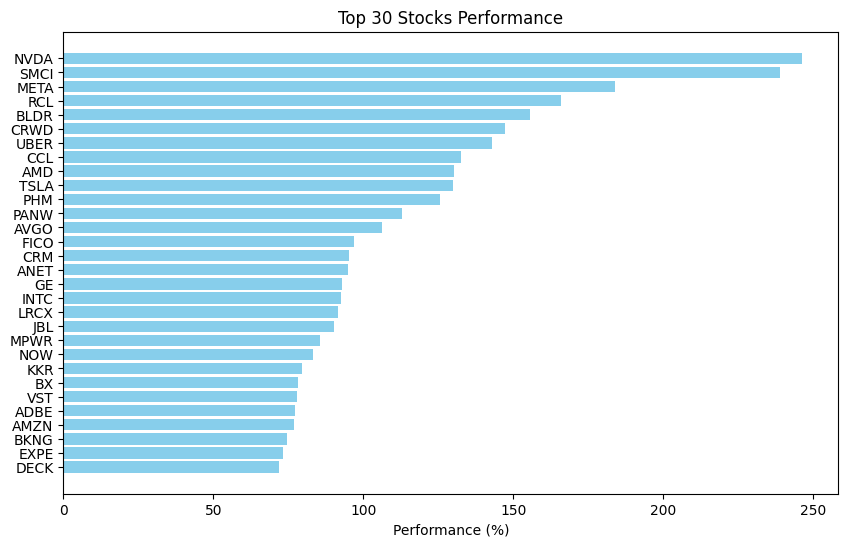

Top 30 Stocks by Sector:
Semiconductors | 5
Travel Services | 4
Software - Application | 4
Software - Infrastructure | 3
Computer Hardware | 2
Asset Management | 2
Internet Content & Information | 1
Building Products & Equipment | 1
Auto Manufacturers | 1
Residential Construction | 1
Aerospace & Defense | 1
Semiconductor Equipment & Materials | 1
Electronic Components | 1
Utilities - Independent Power Producers | 1
Internet Retail | 1
Footwear & Accessories | 1


Bottom 30 Stocks:
DOC | REIT - Healthcare Facilities | -17.6%
PYPL | Credit Services | -17.7%
CTVA | Agricultural Inputs | -17.7%
SJM | Packaged Foods | -18.1%
KVUE | Household & Personal Products | -18.4%
GIS | Packaged Foods | -19.4%
IFF | Specialty Chemicals | -20.1%
CPB | Packaged Foods | -20.7%
INCY | Biotechnology | -21.1%
D | Utilities - Regulated Electric | -21.2%
BAX | Medical Instruments & Supplies | -22.0%
RVTY | Diagnostics & Research | -22.4%
CAG | Packaged Foods | -23.1%
BIO | Medical Devices | -23.6%
ES | Utilit

In [77]:
# Parameters
index = 'SPX'  # Change to 'QQQ' for Nasdaq-100, 'DOW' for Dow Jones, 'IWM' for Russell 2000
df = df_spx
period = '1y'  # Options: 'ytd', '1d', '5d', '1m', '6m', '1y', '2y', '3y', '5y', '10y', '20y'
top_n = 30
bottom_n = 30
start_date = '2023-01-01'  # Example: '2004-01-01'
end_date = '2023-12-31'  # Example: '2024-12-31'
include_industry = True  # Change to False if you want to exclude the industry column

# Get top and bottom performing stocks in separate DataFrames
top_df, bottom_df = get_top_bottom_stocks(df, period, top_n, bottom_n, start_date, end_date)

# Print the DataFrames in table format
print_top_bottom_stocks(top_df, bottom_df, top_n, bottom_n, include_industry=False)

In [79]:
import pandas as pd
from datetime import datetime
import yfinance as yf

def calculate_performance(symbol, start_date, end_date):
    stock = yf.Ticker(symbol)
    hist = stock.history(start=start_date, end=end_date)
    
    if len(hist) == 0:
        return None
    
    start_price = hist['Close'].iloc[0]
    end_price = hist['Close'].iloc[-1]
    performance = (end_price - start_price) / start_price
    return performance

def fetch_all_performance_data(df, start_date, end_date):
    performance_data = []
    for _, row in df.iterrows():
        symbol = row['Symbol']
        company = row['Company']
        sector = row['Sector']
        industry = row['Industry']
        performance = calculate_performance(symbol, start_date, end_date)
        if performance is not None:
            performance_data.append((symbol, company, performance, sector, industry))
    performance_data.sort(key=lambda x: x[2], reverse=True)
    return performance_data

def fetch_yearly_performance_data(df, start_year, end_year, top_n, bottom_n):
    yearly_top_stocks = []
    yearly_bottom_stocks = []
    
    for year in range(start_year, end_year + 1):
        # Define start and end dates for the year
        start_date = f'{year}-01-01'
        if year == datetime.now().year:
            end_date = datetime.now().strftime('%Y-%m-%d')  # YTD for the current year
        else:
            end_date = f'{year}-12-31'
        
        try:
            # Fetch performance data for the current year
            performance_data = fetch_all_performance_data(df, start_date, end_date)
            
            # Get top and bottom performing stocks for the year
            top_stocks = performance_data[:top_n]
            bottom_stocks = performance_data[-bottom_n:]
            
            # Store the results
            yearly_top_stocks.append((year, top_stocks))
            yearly_bottom_stocks.append((year, bottom_stocks))
        except Exception as e:
            print(f"Error fetching data for year {year}: {e}")
    
    return yearly_top_stocks, yearly_bottom_stocks

def format_yearly_data(yearly_data):
    formatted_data = []
    for year, data in yearly_data:
        for stock in data:
            formatted_data.append((year, *stock))
    return formatted_data

In [88]:
# Parameters for fetching and displaying performance data
index = 'SPX'  # Set your desired index
# Example DataFrame
df = df_spx if index == 'SPX' else df_qqq
start_year = 2019  # Set your desired start year
end_year = 2024  # Set your desired end year
top_n = 30  # Number of top stocks to display per year
bottom_n = 30  # Number of bottom stocks to display per year

# Fetch and process yearly performance data
yearly_top_stocks, yearly_bottom_stocks = fetch_yearly_performance_data(df, start_year, end_year, top_n, bottom_n)

# Format the results
formatted_top_stocks = format_yearly_data(yearly_top_stocks)
formatted_bottom_stocks = format_yearly_data(yearly_bottom_stocks)

# Convert results to DataFrame for better readability
yearly_top_stocks_df = pd.DataFrame(formatted_top_stocks, columns=['Year', 'Symbol', 'Company', 'Performance', 'Sector', 'Industry'])
yearly_bottom_stocks_df = pd.DataFrame(formatted_bottom_stocks, columns=['Year', 'Symbol', 'Company', 'Performance', 'Sector', 'Industry'])

# Format the Performance column to display as percentage with one decimal place
yearly_top_stocks_df['Performance'] = yearly_top_stocks_df['Performance'].apply(lambda x: f"{x * 100:.1f}%")
yearly_bottom_stocks_df['Performance'] = yearly_bottom_stocks_df['Performance'].apply(lambda x: f"{x * 100:.1f}%")

# # Display the results
# print("\nTop Stocks Each Year:")
# print(yearly_top_stocks_df.to_string(index=False))
# print("\nBottom Stocks Each Year:")
# print(yearly_bottom_stocks_df.to_string(index=False))

$BRK.B: possibly delisted; No timezone found
CEG: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
ABNB: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
CARR: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
GEV: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
OTIS: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
KVUE: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
GEHC: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
SW: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
VLTO: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
$BF.B: possibly delisted; No price data found  (1d 2019-01-01 -> 2019-12-31)


$BF.B: possibly delisted; No price data found  (1d 2019-01-01 -> 2019-12-31)


SOLV: Data doesn't exist for startDate = 1546318800, endDate = 1577768400
$BRK.B: possibly delisted; No timezone found
CEG: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
GEV: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
KVUE: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
GEHC: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
SW: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
VLTO: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
$BF.B: possibly delisted; No price data found  (1d 2020-01-01 -> 2020-12-31)


$BF.B: possibly delisted; No price data found  (1d 2020-01-01 -> 2020-12-31)


SOLV: Data doesn't exist for startDate = 1577854800, endDate = 1609390800
$BRK.B: possibly delisted; No timezone found
CEG: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
GEV: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
KVUE: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
GEHC: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
SW: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
VLTO: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
$BF.B: possibly delisted; No price data found  (1d 2021-01-01 -> 2021-12-31)


$BF.B: possibly delisted; No price data found  (1d 2021-01-01 -> 2021-12-31)


SOLV: Data doesn't exist for startDate = 1609477200, endDate = 1640926800
$BRK.B: possibly delisted; No timezone found
GEV: Data doesn't exist for startDate = 1641013200, endDate = 1672462800
KVUE: Data doesn't exist for startDate = 1641013200, endDate = 1672462800
SW: Data doesn't exist for startDate = 1641013200, endDate = 1672462800
VLTO: Data doesn't exist for startDate = 1641013200, endDate = 1672462800
$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2022-12-31)


$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2022-12-31)


SOLV: Data doesn't exist for startDate = 1641013200, endDate = 1672462800
$BRK.B: possibly delisted; No timezone found
GEV: Data doesn't exist for startDate = 1672549200, endDate = 1703998800
$RMD: possibly delisted; No price data found  (1d 2023-01-01 -> 2023-12-31)


$RMD: possibly delisted; No price data found  (1d 2023-01-01 -> 2023-12-31)


SW: Data doesn't exist for startDate = 1672549200, endDate = 1703998800
$BF.B: possibly delisted; No price data found  (1d 2023-01-01 -> 2023-12-31)


$BF.B: possibly delisted; No price data found  (1d 2023-01-01 -> 2023-12-31)


SOLV: Data doesn't exist for startDate = 1672549200, endDate = 1703998800
$BRK.B: possibly delisted; No timezone found
SW: Period '1mo' is invalid, must be one of ['1d', '5d', 'ytd', 'max']
$BF.B: possibly delisted; No price data found  (1d 2024-01-01 -> 2024-07-10)


$BF.B: possibly delisted; No price data found  (1d 2024-01-01 -> 2024-07-10)


In [89]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Font

# Assuming you have the DataFrames yearly_top_stocks_df and yearly_bottom_stocks_df

file_name = "top_bottom_stocks_sqx.xlsx" if index == 'SPX' else "top_bottom_stocks_qqq.xlsx"

# Create a new Excel writer object
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    top_combined_df = pd.DataFrame()
    bottom_combined_df = pd.DataFrame()
    
    for year in range(start_year, end_year + 1):
        # Filter data for the current year
        top_df_year = yearly_top_stocks_df[yearly_top_stocks_df['Year'] == year].reset_index(drop=True)
        bottom_df_year = yearly_bottom_stocks_df[yearly_bottom_stocks_df['Year'] == year].reset_index(drop=True)
        
        # Remove year from column titles
        top_df_year.columns = top_df_year.columns.str.replace(f'{year} ', '')
        bottom_df_year.columns = bottom_df_year.columns.str.replace(f'{year} ', '')
        
        # Combine with a divider
        top_combined_df = pd.concat([top_combined_df, top_df_year], axis=1)
        bottom_combined_df = pd.concat([bottom_combined_df, bottom_df_year], axis=1)

    # Write the combined DataFrames to separate sheets in the Excel file
    top_combined_df.to_excel(writer, sheet_name='Top Stocks', index=False)
    bottom_combined_df.to_excel(writer, sheet_name='Bottom Stocks', index=False)

# Highlight the year columns
wb = load_workbook(file_name)

def highlight_year_columns(sheet):
    for col in sheet.iter_cols(min_row=1, max_row=1):
        if 'Year' in col[0].value:
            for cell in col:
                cell.font = Font(bold=True, color="FF0000")

highlight_year_columns(wb['Top Stocks'])
highlight_year_columns(wb['Bottom Stocks'])

wb.save(file_name)